# **Process pseudobulks for subtype prediction**


You will run this 3 times, one for cellType, granular, and subtype pseudobulks
You can edit this in the parameters res_name and celltype_name


# **Imports**

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-01-08 20:09:25.214471: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 20:09:25.214910: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 20:09:25.217311: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 20:09:25.223217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736392165.232634 2559779 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736392165.23

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/GSE192898_pseudobulks/"


exp_id = "all-granular" # cellType subtype granular

if exp_id == "all-cellType":
    res_id = "cellType" 
elif exp_id == "all-granular":
    res_id = "celltype_granular"
elif exp_id == "all_subtype":
    res_id = "subtype"


curr_treatment = "drug"
result_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [3]:
# now get the sc ref training data

# read in order
# oritinal samples
sample_order = ['ovCHA004',
                'ovCHA110',
                'ovCHA017',
                'ovCHA018',
                'ovCHA034',
                'ovCHA039',
                'ovCHA066',
                'ovCHA070']


X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, _, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])



ovCHA004
ovCHA110
ovCHA017
ovCHA018
ovCHA034
ovCHA039
ovCHA066
ovCHA070


In [4]:
gene_df

gene_ids
A1BG            A1BG
A1BG-AS1    A1BG-AS1
A2M              A2M
A2M-AS1      A2M-AS1
A2ML1          A2ML1
              ...   
ZXDC            ZXDC
ZYG11A        ZYG11A
ZYG11B        ZYG11B
ZYX              ZYX
ZZEF1          ZZEF1
Name: gene_ids, Length: 26140, dtype: object

In [5]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type
0,ovCHA004,CTRL,Train,random,sc_ref
1,ovCHA004,CTRL,Train,random,sc_ref
2,ovCHA004,CTRL,Train,random,sc_ref
3,ovCHA004,CTRL,Train,random,sc_ref
4,ovCHA004,CTRL,Train,random,sc_ref
...,...,...,...,...,...
1295,ovCHA070,CTRL,Train,cell_type_specific,sc_ref
1296,ovCHA070,CTRL,Train,cell_type_specific,sc_ref
1297,ovCHA070,CTRL,Train,cell_type_specific,sc_ref
1298,ovCHA070,CTRL,Train,cell_type_specific,sc_ref


In [6]:
X_concat

gene_ids,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,90.0,12.0,531.0,0.0,0.0,3.0,0.0,70.0,0.0,44.0,...,21.0,17.0,19.0,4.0,19.0,18.0,0.0,29.0,664.0,42.0
0,58.0,4.0,257.0,2.0,1.0,4.0,0.0,63.0,0.0,33.0,...,11.0,11.0,21.0,9.0,11.0,28.0,1.0,27.0,593.0,35.0
0,129.0,9.0,626.0,1.0,0.0,0.0,0.0,47.0,0.0,41.0,...,12.0,18.0,16.0,4.0,8.0,21.0,0.0,26.0,614.0,44.0
0,178.0,11.0,907.0,3.0,0.0,1.0,0.0,85.0,0.0,61.0,...,16.0,15.0,15.0,14.0,12.0,26.0,0.0,34.0,774.0,56.0
0,153.0,12.0,913.0,3.0,0.0,3.0,0.0,98.0,0.0,63.0,...,17.0,19.0,14.0,9.0,15.0,22.0,1.0,35.0,757.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,245.0,33.0,127.0,38.0,4.0,0.0,0.0,411.0,0.0,369.0,...,56.0,78.0,109.0,6.0,24.0,87.0,8.0,169.0,3255.0,109.0
0,271.0,48.0,190.0,43.0,4.0,0.0,0.0,430.0,0.0,376.0,...,42.0,103.0,119.0,8.0,21.0,76.0,16.0,166.0,3140.0,113.0
0,264.0,47.0,163.0,41.0,9.0,0.0,0.0,408.0,0.0,360.0,...,38.0,94.0,160.0,7.0,24.0,61.0,5.0,176.0,3164.0,109.0
0,279.0,39.0,180.0,36.0,6.0,0.0,0.0,413.0,0.0,357.0,...,49.0,97.0,116.0,3.0,19.0,88.0,9.0,145.0,3200.0,113.0


In [7]:
# double check all the pseudobulks/bulks were read in
meta_concat.sample_id.value_counts()

ovCHA004    1300
ovCHA110    1300
ovCHA017    1300
ovCHA018    1300
ovCHA034    1300
ovCHA039    1300
ovCHA066    1300
ovCHA070    1300
Name: sample_id, dtype: int64

In [8]:
Y_concat

,immune,stromal,tumor
0,0.495000,0.375000,0.130000
0,0.710000,0.110000,0.180000
0,0.505000,0.480000,0.015000
0,0.100000,0.855000,0.045000
0,0.135000,0.790000,0.075000
...,...,...,...
0,0.000873,0.001190,0.997937
0,0.005445,0.010981,0.983574
0,0.000811,0.006867,0.992323
0,0.016825,0.004661,0.978514


# Plot all data

In [9]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type
0,ovCHA004,CTRL,Train,random,sc_ref
1,ovCHA004,CTRL,Train,random,sc_ref
2,ovCHA004,CTRL,Train,random,sc_ref
3,ovCHA004,CTRL,Train,random,sc_ref
4,ovCHA004,CTRL,Train,random,sc_ref
...,...,...,...,...,...
1295,ovCHA070,CTRL,Train,cell_type_specific,sc_ref
1296,ovCHA070,CTRL,Train,cell_type_specific,sc_ref
1297,ovCHA070,CTRL,Train,cell_type_specific,sc_ref
1298,ovCHA070,CTRL,Train,cell_type_specific,sc_ref


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.043s...
[t-SNE] Computed neighbors for 1000 samples in 0.212s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 21391.445090
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.344986
[t-SNE] KL divergence after 500 iterations: 0.361900
(1000, 2)
(1000, 2)


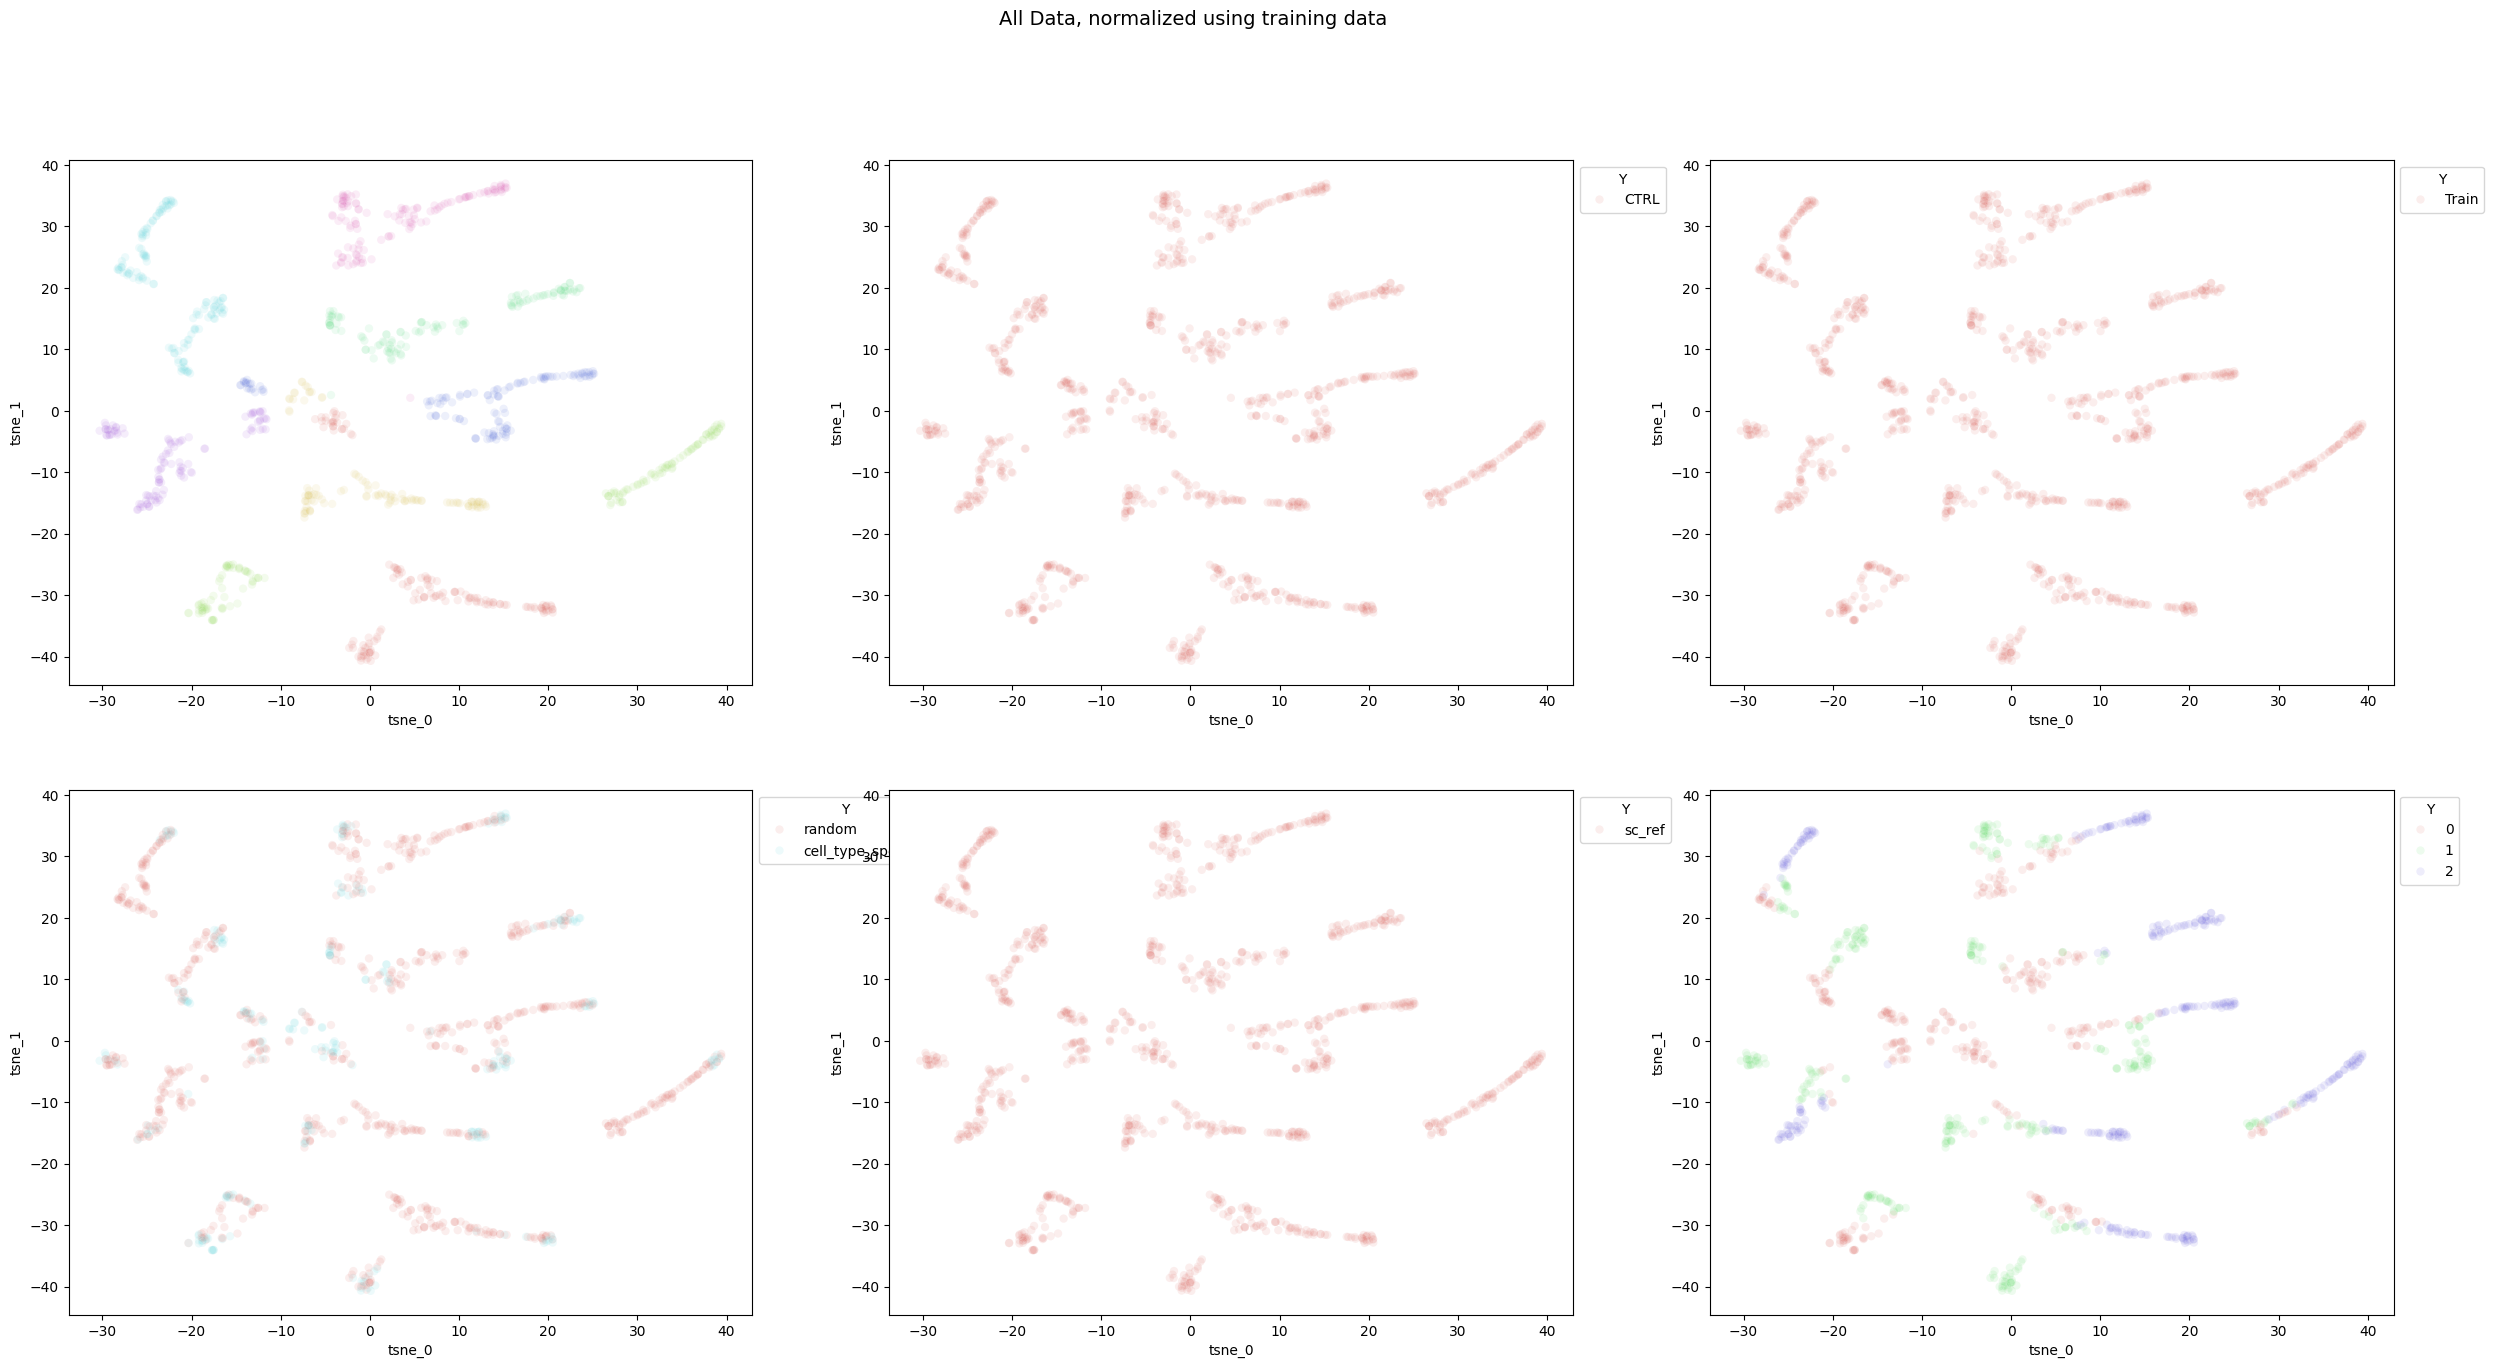

In [10]:
## plot samples
idx_tmp = np.random.choice(range(X_concat.shape[0]), 1000, replace=True)


plot_df = vp.get_tsne_for_plotting(X_concat.iloc[idx_tmp])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_concat.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


In [11]:
Y_concat

,immune,stromal,tumor
0,0.495000,0.375000,0.130000
0,0.710000,0.110000,0.180000
0,0.505000,0.480000,0.015000
0,0.100000,0.855000,0.045000
0,0.135000,0.790000,0.075000
...,...,...,...
0,0.000873,0.001190,0.997937
0,0.005445,0.010981,0.983574
0,0.000811,0.006867,0.992323
0,0.016825,0.004661,0.978514


In [12]:
X_concat

gene_ids,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,90.0,12.0,531.0,0.0,0.0,3.0,0.0,70.0,0.0,44.0,...,21.0,17.0,19.0,4.0,19.0,18.0,0.0,29.0,664.0,42.0
0,58.0,4.0,257.0,2.0,1.0,4.0,0.0,63.0,0.0,33.0,...,11.0,11.0,21.0,9.0,11.0,28.0,1.0,27.0,593.0,35.0
0,129.0,9.0,626.0,1.0,0.0,0.0,0.0,47.0,0.0,41.0,...,12.0,18.0,16.0,4.0,8.0,21.0,0.0,26.0,614.0,44.0
0,178.0,11.0,907.0,3.0,0.0,1.0,0.0,85.0,0.0,61.0,...,16.0,15.0,15.0,14.0,12.0,26.0,0.0,34.0,774.0,56.0
0,153.0,12.0,913.0,3.0,0.0,3.0,0.0,98.0,0.0,63.0,...,17.0,19.0,14.0,9.0,15.0,22.0,1.0,35.0,757.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,245.0,33.0,127.0,38.0,4.0,0.0,0.0,411.0,0.0,369.0,...,56.0,78.0,109.0,6.0,24.0,87.0,8.0,169.0,3255.0,109.0
0,271.0,48.0,190.0,43.0,4.0,0.0,0.0,430.0,0.0,376.0,...,42.0,103.0,119.0,8.0,21.0,76.0,16.0,166.0,3140.0,113.0
0,264.0,47.0,163.0,41.0,9.0,0.0,0.0,408.0,0.0,360.0,...,38.0,94.0,160.0,7.0,24.0,61.0,5.0,176.0,3164.0,109.0
0,279.0,39.0,180.0,36.0,6.0,0.0,0.0,413.0,0.0,357.0,...,49.0,97.0,116.0,3.0,19.0,88.0,9.0,145.0,3200.0,113.0


In [13]:
pd.DataFrame(gene_df)

,gene_ids
gene_ids,
A1BG,A1BG
A1BG-AS1,A1BG-AS1
A2M,A2M
A2M-AS1,A2M-AS1
A2ML1,A2ML1
...,...
ZXDC,ZXDC
ZYG11A,ZYG11A
ZYG11B,ZYG11B


In [14]:
result_ad_file_tsv = f"{sc_aug_data_path}/{exp_id}.tsv"
X_concat.to_csv(result_ad_file_tsv, sep="\t")

In [15]:
result_ad_file

'/var/projects/proportion_subtype_predictor/code/2_format_write_pseudobulk/../../data/single_cell/GSE192898_pseudobulks//all-granular.h5ad'

In [16]:

# make anndata

# write out anndata for R to run consensusOV

meta_concat.index = range(0,meta_concat.shape[0])
Y_concat.index = meta_concat.index
X_concat.index = meta_concat.index
X_concat.columns

full_meta = pd.concat([meta_concat, Y_concat], axis=1)

adata = ad.AnnData(X=X_concat, obs=full_meta, var=pd.DataFrame(gene_df))

adata.write(result_ad_file)

adata

/tmp/ipykernel_2559779/4003203352.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=X_concat, obs=full_meta, var=pd.DataFrame(gene_df))
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 10400 × 26140
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'immune', 'stromal', 'tumor'
    var: 'gene_ids'